<a href="https://colab.research.google.com/github/AbdulmagedALKHULAIFI/Automatic-classifer-consumer-goods/blob/main/p6_2_IMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# pip install --upgrade pip

In [3]:
# pip install --upgrade Pillow

In [4]:
# pip install opencv-python==3.4.2.17

In [5]:
# pip install opencv-contrib-python==3.4.2.17

#Import

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2

In [7]:
#Variable globales
imgs_path = "/content/drive/MyDrive/OC/Projet 6/data/Images/"
preprocessed_imgs_path = '/content/drive/MyDrive/OC/Projet 6/data/preprocessed_images/'


# Analyses exploratoires

In [8]:
data = pd.read_csv("/content/drive/MyDrive/OC/Projet 6/flipkart_com-ecommerce_sample_1050.csv")
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


#Prétraitement des images

In [9]:
df_pict = data[['product_name', 'description','image']].copy('deep')

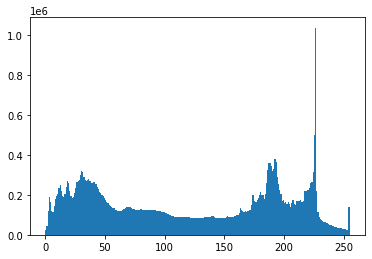

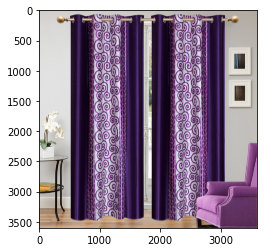

In [10]:
img1_fullname = imgs_path+df_pict['image'].iloc[0]

# Charger l'image comme matrice de pixels
img_matrix = np.array(Image.open(img1_fullname))

n, bins, patches = plt.hist(img_matrix.flatten(), bins=range(256))
plt.show()

img = cv2.imread(img1_fullname)
RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display image
plt.imshow(RGB_im)



In [11]:
def resize_image(img, size, interpolation):
    """Function to resize image without deformation."""
    
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    
    if h == w: return cv2.resize(img, (size, size), interpolation)
    if h > w: dif = h 
    else:     dif = w
        
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    
    if c is None:
        # mask = np.zeros((dif, dif), dtype=img.dtype)
        mask = np.full((dif, dif), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        
    else:
        # mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask = np.full((dif, dif, c), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
        
    return cv2.resize(mask, (size, size), interpolation)

(224, 224, 3)


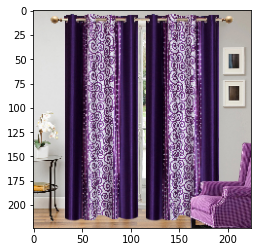

In [12]:
squared_image=resize_image(RGB_im, size=224, interpolation=cv2.INTER_AREA)
print(squared_image.shape)
plt.imshow(squared_image)

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)


(224, 224, 3)


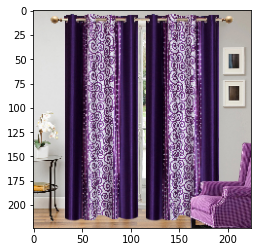

In [14]:
squared_image=resize_image(RGB_im, size=224, interpolation=cv2.INTER_AREA)
print(squared_image.shape)
plt.imshow(squared_image)

In [15]:
dir_read = imgs_path
dir_write = preprocessed_imgs_path

def preprocess_images():

  # for each product in the data
  for index, row in df_pict.iterrows():
      
      # get url of the product's image
      img_name = row['image']
      
      # create the path to the image file
      img_path = dir_read+img_name
      
      # Read the file and convert it to color image
      img_file = cv2.imread(img_path)
      img_rgb = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)
      
      # resize the image to 224*224 pixels
      img_sqr = resize_image(img_rgb, size=224, interpolation=cv2.INTER_AREA)
      
      # auto-adjustment of contrast and luminosity
      img_preprocessed, alpha, beta = automatic_brightness_and_contrast(img_sqr)
      
      # save the preprocessed image
      img_preprocessed_path = dir_write+img_name
      cv2.imwrite(img_preprocessed_path, img_preprocessed)

In [16]:
# preprocess_images()

# Modelisation


##  Extraction des features et *descripteurs*

### ORB

In [17]:
def get_descriptors(model,image_path):
    
    # load image and convert it to grayscale
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # detect key points and descriptors
    keypoints, descriptors = model.detectAndCompute(img_gray, None)

    # returns keypoints and descriptors
    return keypoints, descriptors

In [18]:
orb = cv2.ORB_create()


In [19]:
img_keypoints, img_descriptors = get_descriptors(orb,img1_fullname)

In [20]:
img_descriptors

array([[  9, 221, 115, ..., 144, 107, 141],
       [ 57, 141, 107, ..., 186, 112,   8],
       [ 76, 189,  17, ...,   2,   7, 190],
       ...,
       [ 56,  21, 108, ...,  79, 220, 211],
       [ 89, 187,  88, ..., 132, 236, 125],
       [194, 100,  27, ...,  80, 167, 250]], dtype=uint8)

(-0.5, 3599.5, 3599.5, -0.5)

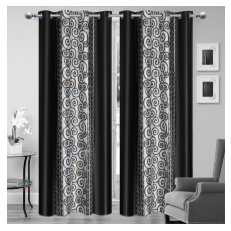

In [21]:
# get descriptors of the image
img_keypoints, img_descriptors = get_descriptors(orb,img1_fullname)

# get the image in gray
img_gray = cv2.imread(img1_fullname, cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gray)

# melt the image with keypoints
img_kp = cv2.drawKeypoints(
    image=img_gray,
    keypoints=img_keypoints,
    outImage=None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# show the grey image with keypoints
plt.imshow(img_kp)
plt.axis('off')

In [22]:
print("We get, for each image, {} keypoints and descriptors of {} dimensions."
      .format(img_descriptors.shape[0], img_descriptors.shape[1]))

We get, for each image, 500 keypoints and descriptors of 32 dimensions.


In [23]:
def attribute_images_descriptors(data,img_directory_path,algo,new_column_name):
  
  data.loc[:,new_column_name] = pd.Series(index=data.index)
  data[new_column_name] = data[new_column_name].astype(object)

  # computing descriptors for each image of product
  for index, row in data.iterrows():
      
      # get url of the product's image
      img_name = row['image']
      
      # create the path to the image file
      img_path = img_directory_path + img_name
      
      # get the keypoints and descriptors of image
      img_keypoints, img_descriptors = get_descriptors(algo,img_path)
      
      # add descriptors into a new column of the dataframe
      data.at[index, new_column_name] = img_descriptors

  return data

In [24]:
data = attribute_images_descriptors(data,preprocessed_imgs_path,orb,'orb_descriptors')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
data = data[['description','image','orb_descriptors']]
data.head(3)

,description,image,orb_descriptors
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[[73, 176, 190, 189, 75, 95, 177, 121, 118, 25..."
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[[6, 8, 130, 155, 20, 131, 170, 65, 22, 128, 8..."
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[[65, 160, 149, 181, 114, 11, 169, 43, 62, 49,..."


### SIFT

In [26]:
sift = cv2.xfeatures2d.SIFT_create()

In [29]:
data = attribute_images_descriptors(data,preprocessed_imgs_path,sift,'sift_descriptors')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
data.head(3)

,description,image,orb_descriptors,sift_descriptors
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[[73, 176, 190, 189, 75, 95, 177, 121, 118, 25...","[[9.0, 0.0, 1.0, 3.0, 3.0, 2.0, 13.0, 22.0, 11..."
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[[6, 8, 130, 155, 20, 131, 170, 65, 22, 128, 8...","[[119.0, 77.0, 0.0, 0.0, 5.0, 5.0, 0.0, 2.0, 1..."
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[[65, 160, 149, 181, 114, 11, 169, 43, 62, 49,...","[[5.0, 2.0, 2.0, 0.0, 0.0, 13.0, 147.0, 19.0, ..."


# Evaluation